In [1]:
import numpy as np
import matplotlib.pyplot as plt

eval = np.load('./logs/evaluations.npz')

[[1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 1000 1000]
 [1000 1000 1000 100

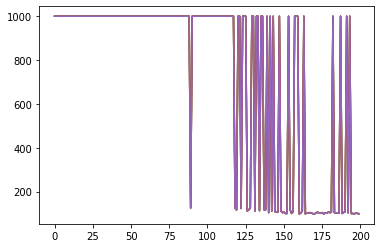

In [2]:
print(eval['ep_lengths'])
plt.plot(eval['ep_lengths'])

In [3]:
# keys are :['ep_lengths', 'results', 'timesteps']

[[ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34430.  -34430.  -34430.  -34430.  -34430.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34850.  -34850.  -34850.  -34850.  -34850.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34760.  -34760.  -34760.  -34760.  -34760.]
 [ -34760.  -34760.  -34760.  -34760.  -34760.]
 [ -34820.  -34820.  -34820.  -34820.  -34820.]
 [ -34820.  -34820.  -34820.  -34820.  -34820.]
 [ -34820.  -34820.  -34820.  -34820.  -34820.]
 [ -34760.  -34760.  -34760.  -34760.  -34760.]
 [ -34700.  -34700.  -34700.  -34700.  -34700.]
 [ -34760.  -34760.  -34760.  -34760.  -34760.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34730.  -34730.  -34730.  -34730.  -34730.]
 [ -34730.  -34730.  -34730.  -34730.  -

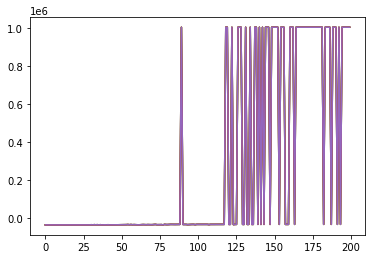

In [4]:
print(eval['results'])
plt.plot(eval['results'])